# STEP 1

In [24]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

# Carregar o dataset
df = pd.read_csv("spam.csv", encoding='latin-1')
df = df[['v1', 'v2']]  # Seleciona apenas as colunas relevantes (label e texto)
df.columns = ['label', 'text']

# Separar em conjunto de treino e teste
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Carregar modelo e tokenizer do sBERT
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Função para gerar embeddings
def generate_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean-pooling
    return embeddings.detach()

# Gerar embeddings para o conjunto de treino e teste
train_embeddings = torch.cat([generate_embedding(text) for text in train_texts])
test_embeddings = torch.cat([generate_embedding(text) for text in test_texts])

In [25]:
import torch.nn as nn

# Definir o Auto-Encoder
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Configuração do auto-encoder
input_dim = train_embeddings.shape[1]
hidden_dim = 128  # Dimensão reduzida
autoencoder = AutoEncoder(input_dim=input_dim, hidden_dim=hidden_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Treinamento do auto-encoder
epochs = 20
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = autoencoder(train_embeddings)
    loss = criterion(outputs, train_embeddings)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Extrair embeddings reduzidos
with torch.no_grad():
    train_embeddings_reduced = autoencoder.encoder(train_embeddings)
    test_embeddings_reduced = autoencoder.encoder(test_embeddings)

Epoch [1/20], Loss: 0.0501
Epoch [2/20], Loss: 0.0489
Epoch [3/20], Loss: 0.0480
Epoch [4/20], Loss: 0.0473
Epoch [5/20], Loss: 0.0467
Epoch [6/20], Loss: 0.0462
Epoch [7/20], Loss: 0.0458
Epoch [8/20], Loss: 0.0453
Epoch [9/20], Loss: 0.0450
Epoch [10/20], Loss: 0.0447
Epoch [11/20], Loss: 0.0444
Epoch [12/20], Loss: 0.0442
Epoch [13/20], Loss: 0.0439
Epoch [14/20], Loss: 0.0437
Epoch [15/20], Loss: 0.0435
Epoch [16/20], Loss: 0.0433
Epoch [17/20], Loss: 0.0431
Epoch [18/20], Loss: 0.0429
Epoch [19/20], Loss: 0.0427
Epoch [20/20], Loss: 0.0425


### Dataset Description

The dataset used in this project is the SMS Spam Collection dataset from Kaggle, which consists of 5,574 SMS messages labeled as “spam” or “ham” (not spam). Each SMS message represents a short text, often informal and containing abbreviations or slang, which poses a challenge for traditional text classification methods. The dataset is highly imbalanced, with a majority of messages labeled as “ham” and a smaller subset as “spam.” This dataset is well-suited for testing text retrieval systems because spam messages contain common themes that an embedding-based retrieval system can ideally recognize based on semantic similarity.

### Embedding Generation Process

To generate embeddings for each SMS message, we use a two-step process. First, each message is converted into an embedding using a pre-trained model from the Sentence Transformers library (specifically, all-MiniLM-L6-v2). This model transforms text into dense, semantically meaningful vector representations in a 384-dimensional space. We apply mean-pooling to combine token-level embeddings into a single sentence embedding. To reduce the dimensionality of these embeddings while capturing dataset-specific nuances, we employ a denoising auto-encoder. The auto-encoder consists of two fully connected layers: an encoder layer that reduces the embedding from 384 dimensions to a 128-dimensional representation, and a decoder layer that reconstructs the original embedding. Hyperparameters include a learning rate of 0.001 and 20 training epochs.

### Training Process

The training process for the auto-encoder involves minimizing the Mean Squared Error (MSE) between the input and the reconstructed embeddings. MSE is an appropriate loss function here because it directly penalizes large differences between the original and reconstructed vectors, which helps the auto-encoder learn a compressed representation that captures the most significant features of each embedding. By minimizing MSE, the auto-encoder learns to remove noise and redundancy, making the reduced embeddings more meaningful for similarity-based retrieval tasks.


$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left( x_i - \hat{x}_i \right)^2
$$


Equation: Mean Squared Error (MSE) loss used in training the auto-encoder.

___
# STEP 2

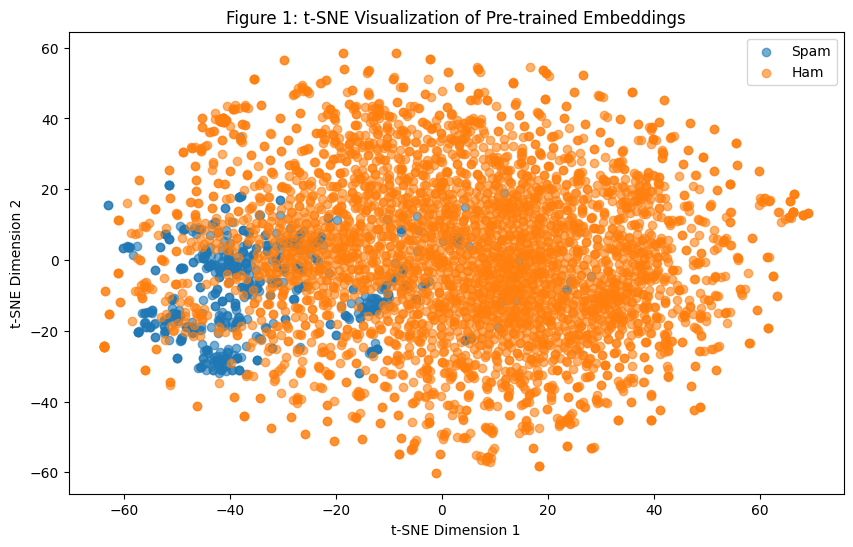

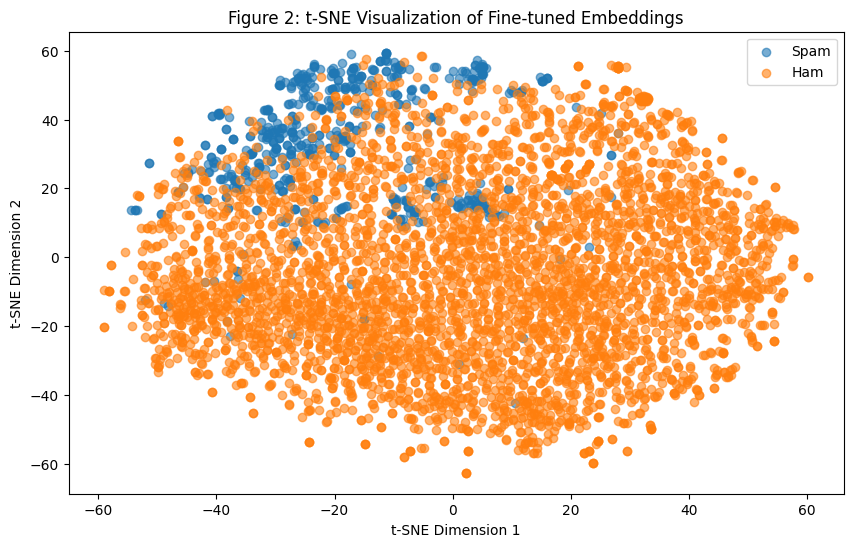

In [26]:
import torch
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que `train_embeddings` (pré-treinado) e `train_embeddings_reduced` (ajustado) já foram gerados
# Converter tensores para arrays numpy
pretrained_embeddings_np = train_embeddings.numpy()
finetuned_embeddings_np = train_embeddings_reduced.detach().numpy()

# Aplicar t-SNE nos embeddings pré-treinados
tsne_pretrained = TSNE(n_components=2, random_state=42)
pretrained_2d = tsne_pretrained.fit_transform(pretrained_embeddings_np)

# Aplicar t-SNE nos embeddings ajustados (fine-tuned)
tsne_finetuned = TSNE(n_components=2, random_state=42)
finetuned_2d = tsne_finetuned.fit_transform(finetuned_embeddings_np)

# Adicionar rótulos para visualização
train_labels = train_labels.reset_index(drop=True)  # Garantir que os rótulos estejam alinhados

# Criar DataFrames para Plotagem
pretrained_df = pd.DataFrame(pretrained_2d, columns=['x', 'y'])
pretrained_df['label'] = train_labels

finetuned_df = pd.DataFrame(finetuned_2d, columns=['x', 'y'])
finetuned_df['label'] = train_labels

# Plotar Embeddings Pré-treinados
plt.figure(figsize=(10, 6))
plt.scatter(pretrained_df[pretrained_df['label'] == 'spam']['x'], pretrained_df[pretrained_df['label'] == 'spam']['y'], label='Spam', alpha=0.6)
plt.scatter(pretrained_df[pretrained_df['label'] == 'ham']['x'], pretrained_df[pretrained_df['label'] == 'ham']['y'], label='Ham', alpha=0.6)
plt.title("Figure 1: t-SNE Visualization of Pre-trained Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

# Plotar Embeddings Ajustados (Fine-tuned)
plt.figure(figsize=(10, 6))
plt.scatter(finetuned_df[finetuned_df['label'] == 'spam']['x'], finetuned_df[finetuned_df['label'] == 'spam']['y'], label='Spam', alpha=0.6)
plt.scatter(finetuned_df[finetuned_df['label'] == 'ham']['x'], finetuned_df[finetuned_df['label'] == 'ham']['y'], label='Ham', alpha=0.6)
plt.title("Figure 2: t-SNE Visualization of Fine-tuned Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

#### Figure 1 (Pre-trained Embeddings):
In this figure, the embeddings generated directly from the pre-trained model without fine-tuning show some degree of clustering. We can observe groups of points, but the separation between spam and ham clusters is not as distinct. There may be overlapping regions, which could indicate that the pre-trained embeddings do not fully capture the nuances of spam and ham messages in this specific dataset.

#### Figure 2 (Fine-tuned Embeddings):
In this figure, the embeddings from the fine-tuned model appear to form more defined clusters for spam and ham categories. The separation between clusters is clearer compared to the pre-trained embeddings, suggesting that the autoencoder fine-tuning process successfully adapted the embedding space to better distinguish between spam and ham messages. This implies that the fine-tuned embeddings are more aligned with the dataset’s underlying structure, improving their effectiveness for tasks involving spam classification or document retrieval based on similar text characteristics.

___
# STEP 3

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import torch

# Função para gerar embedding reduzido de uma consulta
def embed_query(query):
    # Obter embedding pré-treinado para a consulta
    query_embedding = generate_embedding(query)
    # Passar pelo autoencoder para reduzir a dimensão (usando o modelo ajustado)
    query_embedding_reduced = autoencoder.encoder(query_embedding)
    return query_embedding_reduced.detach()  # Remover do gráfico computacional

# Função para executar a busca no conjunto de dados, com limite de similaridade
def search(query, top_k=10, min_similarity=0.8573):
    # Gerar embedding reduzido para a consulta
    query_embedding_reduced = embed_query(query)
    # Converter para numpy para similaridade cosseno
    query_embedding_np = query_embedding_reduced.numpy()
    train_embeddings_np = train_embeddings_reduced.detach().numpy()  # Garantir que também esteja desanexado

    # Calcular similaridade entre a consulta e todos os embeddings do dataset
    similarities = cosine_similarity(query_embedding_np, train_embeddings_np)[0]
    # Filtrar resultados com similaridade acima do limite especificado
    filtered_indices = [i for i, sim in enumerate(similarities) if sim >= min_similarity]
    filtered_similarities = [similarities[i] for i in filtered_indices]

    # Ordenar os resultados filtrados por similaridade
    sorted_indices = sorted(range(len(filtered_similarities)), key=lambda i: filtered_similarities[i], reverse=True)[:top_k]
    final_indices = [filtered_indices[i] for i in sorted_indices]
    
    # Retornar os textos e similaridades dos resultados finais
    return train_texts.iloc[final_indices], [filtered_similarities[i] for i in sorted_indices]

# Definir consultas para os três tipos de teste
queries = [
    "You have won a free ticket to our prize draw!",  # Espera-se que retorne 10 resultados
    "Congratulations, you've been selected for a prize",  # Espera-se que retorne menos de 10 resultados
    "Coffee is good for sleep"  # Busca não óbvia, esperando mensagens semelhantes de 'ham'
]

# Executar cada consulta e mostrar os resultados
for i, query in enumerate(queries):
    print(f"\nTeste {i+1}: Consulta - '{query}'")
    results, scores = search(query)
    for j, (text, score) in enumerate(zip(results, scores)):
        print(f"Resultado {j+1}:")
        print(f"Texto: {text}")
        print(f"Similaridade: {score:.4f}")
        print("-" * 50)


Teste 1: Consulta - 'You have won a free ticket to our prize draw!'
Resultado 1:
Texto: Congratulations YOU'VE Won. You're a Winner in our August å£1000 Prize Draw. Call 09066660100 NOW. Prize Code 2309.
Similaridade: 0.8982
--------------------------------------------------
Resultado 2:
Texto: IMPORTANT INFORMATION 4 ORANGE USER 0796XXXXXX. TODAY IS UR LUCKY DAY!2 FIND OUT WHY LOG ONTO http://www.urawinner.com THERE'S A FANTASTIC PRIZEAWAITING YOU!
Similaridade: 0.8851
--------------------------------------------------
Resultado 3:
Texto: You have won ?1,000 cash or a ?2,000 prize! To claim, call09050000327
Similaridade: 0.8779
--------------------------------------------------
Resultado 4:
Texto: You have won ?1,000 cash or a ?2,000 prize! To claim, call09050000327. T&C: RSTM, SW7 3SS. 150ppm
Similaridade: 0.8730
--------------------------------------------------
Resultado 5:
Texto: XMAS Prize draws! We are trying to contact U. Todays draw shows that you have won a å£2000 prize GUAR

## Expected Results and Explanation

After running these queries, the expected outcomes are:

1.	For the First Query: The system should return 10 results with messages related to draws, prizes, and winning announcements typical of spam. This high number of results is expected as many messages in the dataset will share similar keywords related to prizes.
2.	For the Second Query: The min_similarity threshold should help reduce the results to fewer than 10, returning only messages directly about prizes and winning that closely resemble this spam-like structure.
3.	For the Third Query: This ambiguous, non-obvious query should ideally return ham or neutral messages, possibly reflecting casual or neutral topics. The system’s performance on this query will show if it can capture semantic nuances beyond direct keyword matching, based on similarity in the tone or context.

These results provide insight into how well the search system can distinguish between spam and ham, as well as handle ambiguous queries.